In [52]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_dictionary = pd.read_csv('data_dictionary.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
data_dictionary[['Variable Name', 'Description']]

,Variable Name,Description
0,UniqueID,Identifier for customers
1,loan_default,Payment default in the first EMI on due date
2,disbursed_amount,Amount of Loan disbursed
3,asset_cost,Cost of the Asset
4,ltv,Loan to Value of the asset
5,branch_id,Branch where the loan was disbursed
6,supplier_id,Vehicle Dealer where the loan was disbursed
7,manufacturer_id,"Vehicle manufacturer(Hero, Honda, TVS etc.)"
8,Current_pincode,Current pincode of the customer
9,Date.of.Birth,Date of birth of the customer


In [4]:
#view distribution of classes in target
train['loan_default'].value_counts(normalize=True)

0    0.782929
1    0.217071
Name: loan_default, dtype: float64

In [44]:
train.groupby(['loan_default'])['asset_cost','disbursed_amount'].describe()

asset_cost                                                \
                  count          mean           std      min      25%   
loan_default                                                            
0              182543.0  75722.806128  19015.002867  37000.0  65680.0   
1               50611.0  76378.176661  18680.502609  37000.0  65894.0   

                                          disbursed_amount                \
                  50%      75%        max            count          mean   
loan_default                                                               
0             70845.0  78999.0  1628992.0         182543.0  53826.471111   
1             71326.0  80061.5   281164.0          50611.0  56270.473869   

                                                                          
                       std      min      25%      50%      75%       max  
loan_default                                                              
0             13140.699007  13320.0  46369.0  53303.0  59947.0  990572.0  
1             12150.255527  13369.0  49303.0  55459.0  61947.0  191392.0

In [5]:
#view missing values in columns
train.isna().mean()

UniqueID                               0.000000
disbursed_amount                       0.000000
asset_cost                             0.000000
ltv                                    0.000000
branch_id                              0.000000
supplier_id                            0.000000
manufacturer_id                        0.000000
Current_pincode_ID                     0.000000
Date.of.Birth                          0.000000
Employment.Type                        0.032858
DisbursalDate                          0.000000
State_ID                               0.000000
Employee_code_ID                       0.000000
MobileNo_Avl_Flag                      0.000000
Aadhar_flag                            0.000000
PAN_flag                               0.000000
VoterID_flag                           0.000000
Driving_flag                           0.000000
Passport_flag                          0.000000
PERFORM_CNS.SCORE                      0.000000
PERFORM_CNS.SCORE.DESCRIPTION          0

In [6]:
#take a look at which variables are categorical
train.select_dtypes(include='object').columns

Index(['Date.of.Birth', 'Employment.Type', 'DisbursalDate',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'AVERAGE.ACCT.AGE',
       'CREDIT.HISTORY.LENGTH'],
      dtype='object')

In [75]:
#intialize onehotencoder on training data
enc = OneHotEncoder(sparse = False, handle_unknown='ignore').fit(train[['Employment.Type', 'manufacturer_id','PERFORM_CNS.SCORE.DESCRIPTION', 'State_ID']].fillna('IsNa'))

In [76]:
#create function for date related features to use on train and test set
def preprocessingfeatures(df):
    #get customer age at disbursal
    df['AgeAtDisbursal'] = pd.to_datetime(df['DisbursalDate']).dt.year - pd.to_datetime(df['Date.of.Birth']).dt.year
    #disbursal date info
    df['DisbursalYear'] = pd.to_datetime(df['DisbursalDate']).dt.year
    df['DisbursalMonth'] = pd.to_datetime(df['DisbursalDate']).dt.month
    df['DisbursalWeekday'] = pd.to_datetime(df['DisbursalDate']).dt.weekday
    #parse average acct age field info into months
    df['AVERAGE.ACCT.AGE.MONTHS'] = (df['AVERAGE.ACCT.AGE'].str.split(' ').str[0].str.replace('yrs', '').astype(int) * 12)\
    + (df['AVERAGE.ACCT.AGE'].str.split(' ').str[1].str.replace('mon', '').astype(int))
    #parse credit history length field info into months
    df['CREDIT.HISTORY.LENGTH.MONTHS'] = (df['CREDIT.HISTORY.LENGTH'].str.split(' ').str[0].str.replace('yrs', '').astype(int) * 12)\
    + (df['CREDIT.HISTORY.LENGTH'].str.split(' ').str[1].str.replace('mon', '').astype(int))
    df['PRI.Installment.PCT'] = (df['PRIMARY.INSTAL.AMT'] / df['PRI.DISBURSED.AMOUNT']).replace([np.inf, -np.inf], np.nan).fillna(0)
    df['SEC.Installment.PCT'] = (df['SEC.INSTAL.AMT'] / df['SEC.DISBURSED.AMOUNT']).replace([np.inf, -np.inf], np.nan).fillna(0)
    
    
    return df

In [77]:
def onehotencoding(df):
    df_drop = df.drop(['Date.of.Birth', 'CREDIT.HISTORY.LENGTH','DisbursalYear', 'branch_id','DisbursalDate','supplier_id','manufacturer_id','Employee_code_ID','AVERAGE.ACCT.AGE', 'Current_pincode_ID', 'Employment.Type','manufacturer_id','supplier_id', 'PERFORM_CNS.SCORE.DESCRIPTION','State_ID', 'branch_id'], axis=1)
    df_cat = enc.transform(df[['Employment.Type','manufacturer_id','PERFORM_CNS.SCORE.DESCRIPTION','State_ID']].fillna('IsNa'))
    
    cols = enc.get_feature_names(['Employment.Type','manufacturer_id','PERFORM_CNS.SCORE.DESCRIPTION', 'State_ID'])
    df_cat2 = pd.DataFrame(df_cat)
    df_cat2.columns = cols.tolist()
    df_new = pd.concat([df_drop,df_cat2], axis=1)
    
    return df_new

In [78]:
X = train[train.columns.difference(['loan_default'])]
y = train['loan_default']

In [79]:
X = preprocessingfeatures(X)
X = onehotencoding(X).set_index('UniqueID')

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

In [81]:
X_train.head()

,AVERAGE.ACCT.AGE.MONTHS,Aadhar_flag,AgeAtDisbursal,CREDIT.HISTORY.LENGTH.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,DisbursalMonth,DisbursalWeekday,Driving_flag,MobileNo_Avl_Flag,NEW.ACCTS.IN.LAST.SIX.MONTHS,...,State_ID_13,State_ID_14,State_ID_15,State_ID_16,State_ID_17,State_ID_18,State_ID_19,State_ID_20,State_ID_21,State_ID_22
UniqueID,,,,,,,,,,,,,,,,,,,,,
445041,4,1,35,11,0,8,4,0,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
626473,0,1,36,0,0,10,4,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
528426,0,1,34,0,0,9,5,0,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
618993,10,1,25,22,0,10,3,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
532539,0,1,-52,0,0,9,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
#create dataframe with onehot endcoded features and target for exploratory data analysis in addition to train df
eda = preprocessingfeatures(train)
eda = onehotencoding(eda).set_index('UniqueID')

Pearson Correlation Between loan default target and candidate features for predictive model

In [83]:
pd.DataFrame(eda.corr().sort_values(by = 'loan_default')['loan_default'])

,loan_default
PERFORM_CNS.SCORE,-0.057929
PERFORM_CNS.SCORE.DESCRIPTION_B-Very Low Risk,-0.042176
CREDIT.HISTORY.LENGTH.MONTHS,-0.042126
Aadhar_flag,-0.041593
PRI.ACTIVE.ACCTS,-0.041451
...,...
State_ID_13,0.062586
disbursed_amount,0.077675
ltv,0.098208
loan_default,1.000000


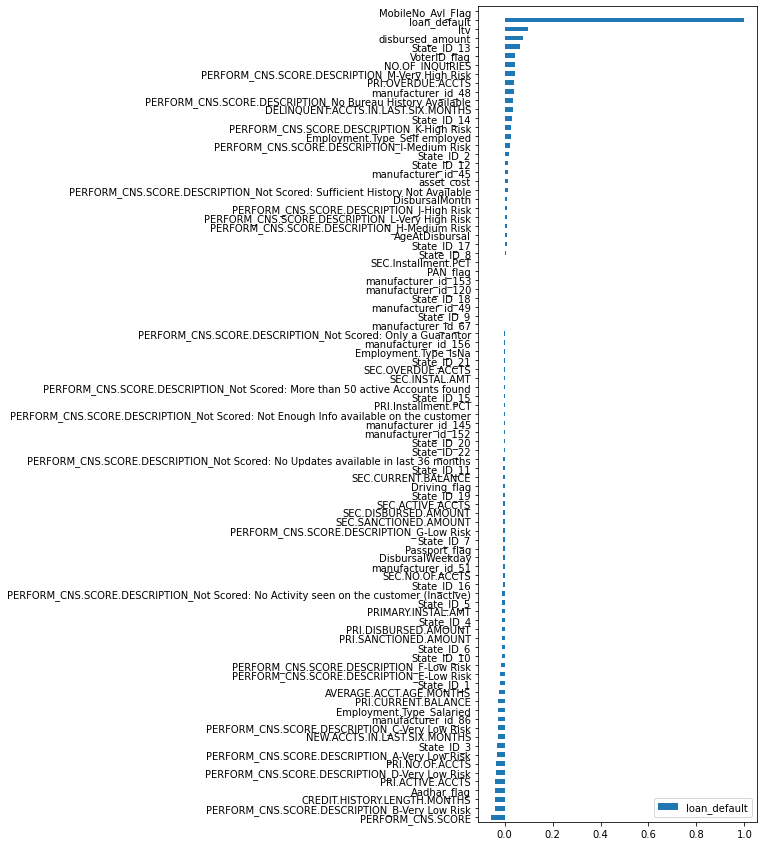

In [84]:
pd.DataFrame(eda.corr().sort_values(by = 'loan_default')['loan_default']).plot(kind = 'barh',figsize=(5,15));

Initialize and train model

In [85]:
clf = LogisticRegression(random_state=42, max_iter=700).fit(X_train, y_train)

In [86]:
#accuracy is misleading here because of class imbalance we saw earlier
clf.score(X_test, y_test)

0.7828697647487722

In [87]:
#confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(y_test,clf.predict(X_test)).ravel()
tn, fp, fn, tp

(36506, 3, 10122, 0)

In [88]:
metrics.f1_score(y_test, clf.predict(X_test), average='binary')

0.0

In [89]:
metrics.roc_auc_score(y_test, clf.predict(X_test))

0.4999589142403243

View logistic regression model coefficients

In [90]:
coefs_df = pd.DataFrame()
coefs_df['est_int'] = X_train.columns
coefs_df['coefs'] = clf.coef_.T.tolist()
coefs_df = coefs_df.explode('coefs')
coefs_df['abs_coefs'] = np.abs(coefs_df['coefs'])
coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
coefs_df

,est_int,coefs,abs_coefs
12,PERFORM_CNS.SCORE,-0.000621617,0.000621617
33,ltv,-5.29315e-05,5.29315e-05
3,CREDIT.HISTORY.LENGTH.MONTHS,-3.2461e-05,3.2461e-05
31,asset_cost,-2.7267e-05,2.7267e-05
16,PRI.Installment.PCT,-2.51731e-05,2.51731e-05
...,...,...,...
28,SEC.OVERDUE.ACCTS,1.14529e-09,1.14529e-09
46,manufacturer_id_153,5.8912e-10,5.8912e-10
45,manufacturer_id_152,-2.27719e-12,2.27719e-12
62,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More...,-2.15425e-12,2.15425e-12


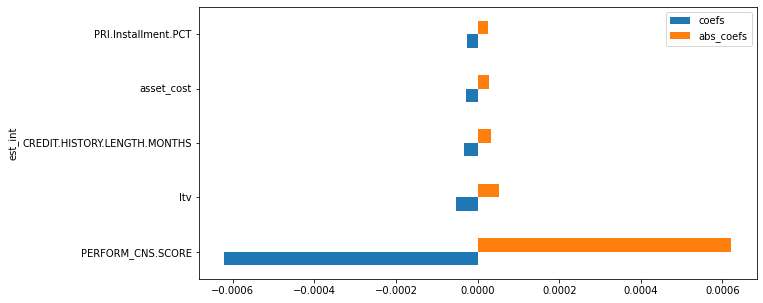

In [91]:
coefs_df.set_index('est_int').sort_values('abs_coefs', ascending=False).head(5).plot(kind = 'barh',figsize=(10,5));

Checking to see if adjusting the threshold would improve performance

In [92]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test,(clf.predict_proba(X_test)[:,1]>=0.3).astype(int)).ravel()
tn, fp, fn, tp

(31788, 4721, 8421, 1701)

In [93]:
metrics.f1_score(y_test, (clf.predict_proba(X_test)[:,1]>=0.3).astype(int), average='binary')

0.20563346228239848

In [94]:
metrics.roc_auc_score(y_test, (clf.predict_proba(X_test)[:,1]>=0.3).astype(int))

0.5193696057892393

Analysis on score and credit history

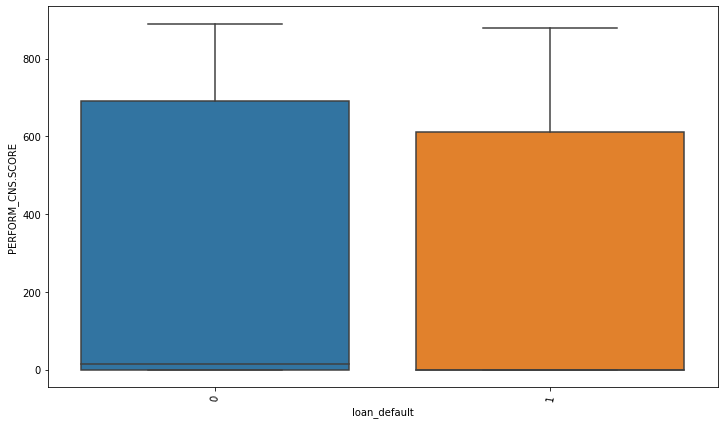

In [95]:
plt.figure(figsize=(12,7))
sn.boxplot(x='loan_default', y="PERFORM_CNS.SCORE", data=train)
plt.xticks(rotation=80);

In [96]:
eda.groupby(['loan_default'])['PERFORM_CNS.SCORE'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,299.784270,342.883794,0.0,0.0,15.0,690.0,890.0
1,50611.0,252.236372,318.826242,0.0,0.0,0.0,610.0,879.0


In [97]:
eda.groupby(['loan_default'])['CREDIT.HISTORY.LENGTH.MONTHS'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,16.886377,29.342245,0.0,0.0,0.0,24.0,449.0
1,50611.0,13.965798,25.519395,0.0,0.0,0.0,21.0,468.0


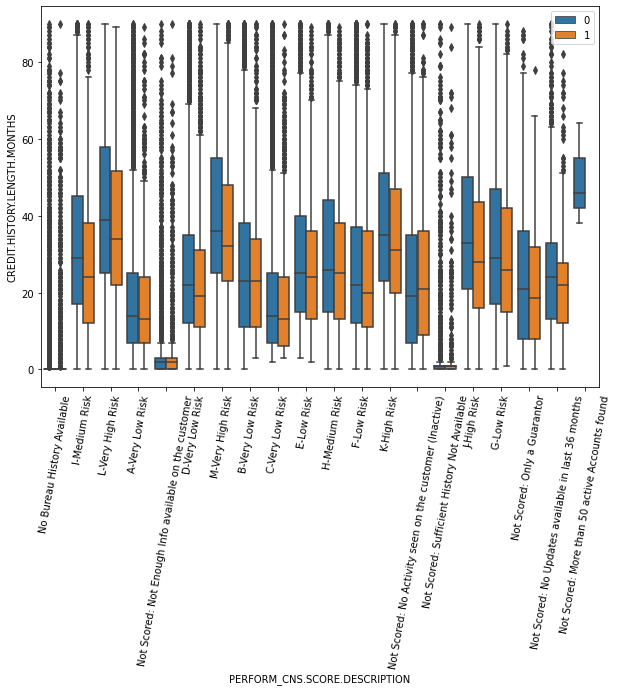

In [98]:
plt.figure(figsize=(10,7))
sn.boxplot(x='PERFORM_CNS.SCORE.DESCRIPTION', y="CREDIT.HISTORY.LENGTH.MONTHS",hue='loan_default',data=train.query('`CREDIT.HISTORY.LENGTH.MONTHS`<=90'))
plt.legend(loc='upper right')
plt.xticks(rotation=80);

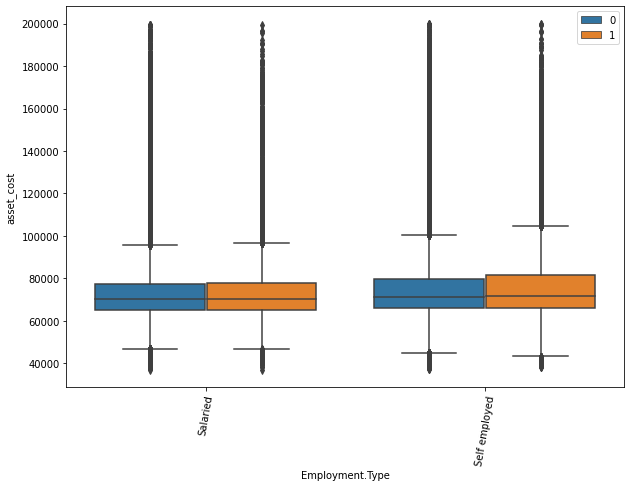

In [99]:
plt.figure(figsize=(10,7))
sn.boxplot(x='Employment.Type', y="asset_cost",hue='loan_default',data=train.query('asset_cost<=200000'))
plt.legend(loc='upper right')
plt.xticks(rotation=80);

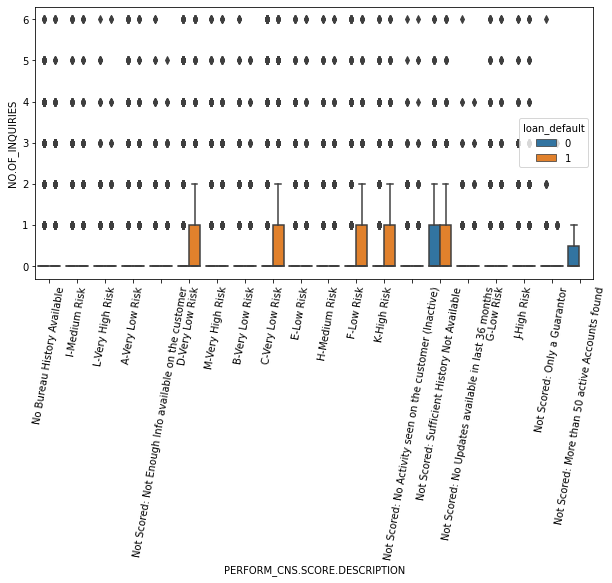

In [100]:
plt.figure(figsize=(10,5))
sn.boxplot(x='PERFORM_CNS.SCORE.DESCRIPTION', y="NO.OF_INQUIRIES",hue="loan_default", data=train.query("`NO.OF_INQUIRIES` <= 6"))
plt.xticks(rotation=80);

In [101]:
train.groupby(['loan_default'])['NO.OF_INQUIRIES'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_default,,,,,,,,
0,182543.0,0.190366,0.665536,0.0,0.0,0.0,0.0,36.0
1,50611.0,0.265219,0.835147,0.0,0.0,0.0,0.0,19.0


Predict unlabeled test set

In [128]:
X1 = test[test.columns.difference(['loan_default'])]
X1 = preprocessingfeatures(X1)

In [129]:
X1 = onehotencoding(X1).set_index('UniqueID')

In [130]:
y_hats = (clf.predict_proba(X1)[:,1]>=0.3).astype(int)
y_probs = clf.predict_proba(X1)

In [145]:
X1['prediction'] = y_hats
X1['predictionprob_true'] = y_probs[:,0]
X1['predictionprob_false'] = y_probs[:,1]

In [146]:
X1.prediction.value_counts()

1    104044
0      8348
Name: prediction, dtype: int64

In [147]:
X1.head()

,Aadhar_flag,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,Driving_flag,MobileNo_Avl_Flag,NEW.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,PAN_flag,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.CURRENT.BALANCE,...,State_ID_16,State_ID_17,State_ID_18,State_ID_19,State_ID_20,State_ID_21,State_ID_22,prediction,predictionprob_false,predictionprob_true
UniqueID,,,,,,,,,,,,,,,,,,,,,
655269,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.544151,0.455849
723482,1,0,0,1,1,1,0,749,1,43898,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.520178,0.479822
758529,1,0,0,1,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.558503,0.441497
763449,1,0,0,1,0,0,0,14,1,132480,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.439716,0.560284
708663,1,0,0,1,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.544406,0.455594
